# Predicting house prices using k-nearest neighbors regression
In this notebook, you will implement k-nearest neighbors regression. You will:
  * Find the k-nearest neighbors of a given query input
  * Predict the output for the query input using the k-nearest neighbors
  * Choose the best value of k using a validation set

In [30]:
import numpy as np
import pandas as pd

# Load in house sales data

In [31]:
sales = pd.read_csv('merged.csv')

In [32]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2450 entries, 0 to 2449
Data columns (total 27 columns):
SALE TYPE                                                                                     2450 non-null object
SOLD DATE                                                                                     965 non-null object
PROPERTY TYPE                                                                                 2450 non-null object
ADDRESS                                                                                       2438 non-null object
CITY                                                                                          2444 non-null object
STATE OR PROVINCE                                                                             2450 non-null object
ZIP OR POSTAL CODE                                                                            2443 non-null float64
PRICE                                                                                   

Note: Create the same features as you did in Project 5.

In [33]:
from math import log, sqrt
sales['sqft_sqrt'] = sales['SQUARE FEET'].apply(sqrt)
sales['lot_sqrt'] = sales['LOT SIZE'].apply(sqrt)
sales['bedrooms_square'] = sales['BEDS']*sales['BEDS']
sales['bath_square'] = sales['BATHS']*sales['BATHS']

# Import useful functions from previous notebooks

To efficiently compute pairwise distances among data points, we will convert the dataframe into a 2D Numpy array. First import the numpy library and then copy and paste `get_numpy_data()` from Project 2.

In [15]:
def get_numpy_data(data, features, output):
    data['Constant'] = 1
    features = ['Constant'] + features
    feature_matrix = data[features].values
    output_array = data[output].values
    return(feature_matrix, output_array)

We will also need the `normalize_features()` function from Project 5 that normalizes all feature columns to unit norm. Paste this function below.

In [34]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    features = feature_matrix / norms
    
    return(features,norms)

# Split data into training, test, and validation sets

split data into training/validation/test data with 64/16/20

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
train_valid,test = train_test_split(sales,test_size = 0.2)

In [37]:
training,validation = train_test_split(train_valid,test_size = 0.2)

# Extract features and normalize

Using all of the numerical inputs listed in `all_features`, transform the sales, the training, test, and validation dataframes into Numpy arrays.

In [38]:
all_features = ['SQUARE FEET', 'LOT SIZE', 
                'BEDS', 'BATHS','YEAR BUILT', 'sqft_sqrt','lot_sqrt','bedrooms_square','bath_square']

In [39]:
sales = sales[all_features+['PRICE']].dropna()

In [40]:
feature_train,output_train = get_numpy_data(training, all_features, "PRICE")
feature_valid,output_valid = get_numpy_data(validation, all_features, "PRICE")
feature_testing,output_testing = get_numpy_data(test, all_features, "PRICE")

/Users/liziwei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In computing distances, it is crucial to normalize features. Otherwise, for example, the `SQUARE FEET` feature (typically on the order of thousands) would exert a much larger influence on distance than the `BEDS` feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.

IMPORTANT: Make sure to store the norms of the features in the sales set. The features in the training, test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

In [41]:
feature_train_norm,norms = normalize_features(feature_train)
feature_valid_norm = feature_valid/norms
feature_testing_norm = feature_testing/norms

In [42]:
# your code # normalize whole set features (columns)
# your code  #normalize training set by the norms
# your code # normalize test set by the norms
# your code # normalize validation set by the norms

# Compute a single distance

To start, let's just explore computing the "distance" between two given houses.  We will take our **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

To see the features associated with the query house, print the 10th row (index 9) of the training feature matrix. You should get an 10-dimensional vector.

In [43]:
feature_train_norm[1]

array([0.02525381,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

In [44]:
feature_train_norm[9]

array([0.02525381,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

Now print the 10th row (index 9) of the training feature matrix. Again, you get an 10-dimensional vector with components between 0 and 1.

In [108]:
# your code

array([ 0.07955573,  0.10427187,  0.06957212,  0.09100315,  0.08508285,
        0.07805936,  0.09625196,  0.10177752,  0.08835061,  0.0684989 ])

What is the Euclidean distance between the query house and the 10th house of the training set?
Note: Do not use the np.linalg.norm function; use np.sqrt, np.sum, and the power operator (**) instead. The latter approach is more easily adapted to computing multiple distances at once.

In [31]:
np.sqrt(np.sum((feature_train_norm[1]-feature_train_norm[9])**2))

0.04162270780475861

# Compute multiple distances

Of course, to do nearest neighbor regression, we need to compute the distance between our query house and *all* houses in the training set.  

To visualize this nearest-neighbor search, let's first compute the distance from our query house (`features_test[0]`) to the first 10 houses of the training set (`features_train[0:10]`) and then search for the nearest neighbor within this small set of houses.  Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.

Write a loop to compute the Euclidean distance from the query house to each of the first 10 houses in the training set.

In [35]:
ind = []
distt = []
dataf1 = pd.DataFrame()
for i in range(10):
    dist = np.sqrt(np.sum((feature_testing_norm[0]-feature_train_norm[i])**2))
    ind.append(i)
    distt.append(dist)
dataf1['Index'] = ind
dataf1['Distance'] = distt
dataf1

,Index,Distance
0,0,0.018817
1,1,0.031840
2,2,0.171262
3,3,0.014935
4,4,0.046056
5,5,0.019386
6,6,0.015956
7,7,0.029291
8,8,0.004446
9,9,0.036968


Among the first 10 training houses, which house is the closest to the query house?

In [36]:
dataf1.iloc[dataf1['Distance'].idxmin()]

Index       8.000000
Distance    0.004446
Name: 8, dtype: float64

It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the Numpy functions can be **vectorized**, applying the same operation over multiple values or vectors.  We now walk through this process.

Consider the following loop that computes the element-wise difference between the features of the query house (`features_test[0]`) and the first 3 training houses (`features_train[0:3]`):

array([0.03106849, 0.01890451, 0.00834287, 0.02774212, 0.02470207,
       0.0307811 , 0.02535525, 0.02922241, 0.02109783, 0.01517869])

In [48]:
for x in range(3):
    z = feature_train_norm[x] - feature_testing_norm[0]
    print(z)

[ 0.00000000e+00  4.53387728e-03  2.92749186e-03  0.00000000e+00
  1.23510335e-02 -4.73312730e-05  3.24859126e-03  5.67881701e-03
  0.00000000e+00  1.13840154e-02]
[0.         0.01541198 0.00307933 0.00924737 0.01235103 0.00028399
 0.00971821 0.00594355 0.01640943 0.01138402]
[0.         0.06893736 0.01072246 0.01849475 0.06175517 0.00070997
 0.03111993 0.01709895 0.03750726 0.13281351]


The subtraction operator (`-`) in Numpy is vectorized as follows:

In [45]:
feature_train_norm[0:3]-feature_testing_norm[0]

array([[ 0.00000000e+00,  4.53387728e-03,  2.92749186e-03,
         0.00000000e+00,  1.23510335e-02, -4.73312730e-05,
         3.24859126e-03,  5.67881701e-03,  0.00000000e+00,
         1.13840154e-02],
       [ 0.00000000e+00,  1.54119786e-02,  3.07933493e-03,
         9.24737470e-03,  1.23510335e-02,  2.83987638e-04,
         9.71820838e-03,  5.94354667e-03,  1.64094252e-02,
         1.13840154e-02],
       [ 0.00000000e+00,  6.89373638e-02,  1.07224566e-02,
         1.84947494e-02,  6.17551676e-02,  7.09969095e-04,
         3.11199250e-02,  1.70989500e-02,  3.75072577e-02,
         1.32813513e-01]])

Note that the output of this vectorized operation is identical to that of the loop above, which can be verified below:

In [53]:
# verify that vectorization works
results = feature_train_norm[0:3] - feature_testing_norm[0]
print (results[0] - (feature_train_norm[0]-feature_testing_norm[0]))
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print (results[1] - (feature_train_norm[1]-feature_testing_norm[0]))
# should print all 0's if results[1] == (features_train[1]-features_test[0])
print (results[2] - (feature_train_norm[2]-feature_testing_norm[0]))
# should print all 0's if results[2] == (features_train[2]-features_test[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Note: it is a good idea to write tests like this cell whenever you are vectorizing a complicated operation.

# Perform 1-nearest neighbor regression

Now that we have the element-wise differences, it is not too hard to compute the Euclidean distances between our query house and all of the training houses. First, write a single-line expression to define a variable `diff` such that `diff[i]` gives the element-wise difference between the features of the query house and the `i`-th training house.

In [55]:
diff = feature_train_norm - feature_testing_norm[0]

To test the code above, run the following cell, which should output a value 0.254292245678:

In [117]:
# your code # sum of the feature differences between the query and last training house
# should print 0.254292245678

0.254292245678


The next step in computing the Euclidean distances is to take these feature-by-feature differences in `diff`, square each, and take the sum over feature indices.  That is, compute the sum of square feature differences for each training house (row in `diff`).

By default, `np.sum` sums up everything in the matrix and returns a single number. To instead sum only over a row or column, we need to specifiy the `axis` parameter described in the `np.sum` [documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.sum.html). In particular, `axis=1` computes the sum across each row.

Below, we compute this sum of square feature differences for all training houses and verify that the output for the 16th house in the training set is equivalent to having examined only the 16th row of `diff` and computing the sum of squares on that row alone.

In [61]:
print (np.sum(diff**2, axis=1)[15]) # take sum of squares across each row, and print the 16th sum
print (np.sum(diff[15]**2)) # print the sum of squares for the 16th row -- should be same as above

0.001711461522170833
0.001711461522170833


With this result in mind, write a single-line expression to compute the Euclidean distances between the query house and all houses in the training set. Assign the result to a variable `distances`.

In [62]:
distance = np.sqrt(np.sum(diff**2, axis=1))

To test the code above, run the following cell, which should output a value 0.095099460935:

In [64]:
distance[1]

0.03184004348027965

In [121]:
# your code # Euclidean distance between the query house and the 101th training house
# should print 0.095099460935

0.095099460935


Now you are ready to write a function that computes the distances from a query house to all training houses. The function should take two parameters: (i) the matrix of training features and (ii) the single feature vector associated with the query.

In [84]:
def distance(feature_matrix,query):
    diff2 = feature_matrix - query
    dist2 = np.sqrt(np.sum(diff2**2, axis=1))
    return dist2

1.  Take the query house to be third house of the test set (`features_test[2]`).  What is the index of the house in the training set that is closest to this query house?
2.  What is the predicted value of the query house based on 1-nearest neighbor regression?

In [76]:
x = distance(feature_train_norm,feature_testing_norm[2])

In [79]:
x.min()

0.003127127090801451

In [78]:
x.argmin()

74

In [81]:
output_train[x.argmin()]

2600000.0

# Perform k-nearest neighbor regression

For k-nearest neighbors, we need to find a set of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

## Fetch k-nearest neighbors

Using the functions above, implement a function that takes in
 * the value of k;
 * the feature matrix for the training houses; and
 * the feature vector of the query house
 
and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.

**Hint**: Look at the [documentation for `np.argsort`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html).

In [85]:
def knn(feature_matrix,query,k):
    diff3 = feature_matrix - query
    dist3 = np.sqrt(np.sum(diff3**2, axis=1))
    value = np.argsort(dist3)
    return value[0:k]

Take the query house to be third house of the test set (`features_test[2]`).  What are the indices of the 4 training houses closest to the query house?

In [86]:
knn(feature_train_norm,feature_testing[2],4)

array([194, 386, 582, 326])

## Make a single prediction by averaging k nearest neighbor outputs

Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query house. **For simplicity, take the average of the prices of the k nearest neighbors in the training set**. The function should have the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature vector of the query house, whose price we are predicting.
 
The function should return a predicted value of the query house.

**Hint**: You can extract multiple items from a Numpy array using a list of indices. For instance, `output_train[[6, 10]]` returns the prices of the 7th and 11th training houses.

In [87]:
def price_estimate(k,feature_matrix,output,query):
    val = knn(feature_matrix,query,k)
    price1 = output[val]
    price2 = price1.mean()
    return price2

Again taking the query house to be third house of the test set (`features_test[2]`), predict the value of the query house using k-nearest neighbors with `k=4` and the simple averaging method described and implemented above.

In [88]:
price_estimate(4,feature_train_norm,output_train,feature_testing_norm[2])

3628750.0

In [128]:
# your code

1892500.0

Compare this predicted value using 4-nearest neighbors to the predicted value using 1-nearest neighbor computed earlier.

## Make multiple predictions

Write a function to predict the value of *each and every* house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function should take the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature matrix for the query set.
 
The function should return a set of predicted values, one for each house in the query set.

**Hint**: To get the number of houses in the query set, use the `.shape` field of the query features matrix. See [the documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.ndarray.shape.html).

In [101]:
def price_estimate_multi(k,feature_matrix,output,query):
    price = []
    for x in range(0,query.shape[0]):
        value = price_estimate(k,feature_matrix,output,query[x])
        price.append(value)
    return price

Make predictions for the first 10 houses in the test set using k-nearest neighbors with `k=5`. 

1. What is the index of the house in this query set that has the lowest predicted value? 
2. What is the predicted value of this house?

In [102]:
s = price_estimate_multi(5,feature_train_norm,output_train,feature_testing_norm[10])

In [104]:
s

[1607700.0,
 1814800.0,
 480000.0,
 1014100.0,
 1014100.0,
 1607700.0,
 1014100.0,
 1111200.0,
 1014100.0,
 847000.0]

## Choosing the best value of k using a validation set

There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:

* For `k` in [1, 2, ..., 15]:
    * Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    * Computes the RSS for these predictions on the VALIDATION set
    * Stores the RSS computed above in `rss_all`
* Report which `k` produced the lowest RSS on VALIDATION set.

In [106]:
rss_all = []
index = []
dataf4 = pd.DataFrame()
for k in range(1,16):
    c1 = price_estimate_multi(k,feature_train_norm,output_train,feature_valid_norm)
    square_error = (c1 - output_valid)**2
    sum_square_error = square_error.sum()
    rss_all.append(sum_square_error)
    index.append(k)
dataf4["RSS"] = rss_all
dataf4["Index"] = index
dataf4

,RSS,Index
0,4.112649e+14,1
1,2.917218e+14,2
2,2.659491e+14,3
3,2.529021e+14,4
4,2.395109e+14,5
5,2.314940e+14,6
6,2.342503e+14,7
7,2.355181e+14,8
8,2.317323e+14,9
9,2.185235e+14,10


To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

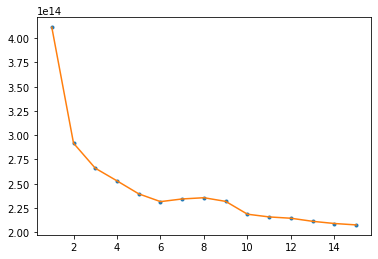

In [110]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(dataf4["Index"],dataf4["RSS"],'.')
plt.plot(dataf4["Index"],dataf4["RSS"],'-')

What is the optimal k? What is the RSS on the TEST data using the value of k found above? To be clear, sum over all houses in the TEST set.

In [114]:
rss_all_2 = []
index_2 = []
dataf5 = pd.DataFrame()
for k in range(1,16):
    c1 = price_estimate_multi(k,feature_train_norm,output_train,feature_testing_norm)
    square_error_2 = (c1 - output_testing)**2
    sum_square_error_2 = square_error_2.sum()
    rss_all_2.append(sum_square_error_2)
    index_2.append(k)
dataf5["RSS"] = rss_all_2
dataf5["Index"] = index_2
dataf5

,RSS,Index
0,4.953116e+14,1
1,3.933997e+14,2
2,3.759043e+14,3
3,3.501049e+14,4
4,3.344911e+14,5
5,3.314831e+14,6
6,3.228954e+14,7
7,3.146828e+14,8
8,3.076783e+14,9
9,3.037844e+14,10


# Cosine Distance

\begin{equation*}
Cosine  Similarity = \frac{\sum_{k=1}^n x_i y_i}{\sqrt{\sum_{k=1}^n x_i^2}\sqrt{\sum_{k=1}^n y_i^2}}
\end{equation*}

\begin{equation*}
Cosine Distance = 1-CosineSimilarity
\end{equation*}

We may define the cosine funcion according to the formula.

In [115]:
from math import sqrt

In [376]:
def cos_dis(feature_1,feature_2):
    dist22 = []
    for x in range(feature_1.shape[0]):
        for y in range(feature_2.shape[0]):
            sim = (np.dot(feature_1[x],feature_2[y])).sum()/sqrt((np.dot(feature_1[x],feature_1[x])).sum())*sqrt((np.dot(feature_2[y],feature_2[y])).sum())
            dis = 1 - sim
        dist22.append(dis)
    return dist22

In [375]:
cos_dis(feature_train_norm,feature_testing_norm[1])

1036

In [143]:
# After that, we can get distance from one point from test set to every point in train 
# size. 

After getting each point, we need to sort the values from the smallest to the largest and pick out the first k values according to the KNN algorithm.

Then, I will write another function include K and print out the first K values's index.

In [377]:
def cos_d_k(k,feature_1,feature_2):
    dista = cos_dis(feature_1,feature_2)
    values = np.argsort(dista)
    return values[0:k]

In [378]:
cos_d_k(4,feature_train_norm,feature_testing_norm[0])

array([843, 937, 919, 272])

Then, define a new function including output and return the price

In [379]:
def cos_d_k_pri(k,feature_1,feature_2,output):
    for x in range(0,k):
        ind = cos_d_k(k,feature_1,feature_2)
        pre = output[ind]
        pre2 = pre.mean()
        return pre2

In [380]:
cos_d_k_pri(4,feature_train_norm,feature_testing_norm[0],output_train)

1009125.0

In [381]:
def cos_d_mean(k,feature_1,feature_2,output):
    price3 = []
    for x in range(1,k+1):
        va = cos_d_k_pri(x,feature_1,feature_2,output)
        price3.append(va)
    return price3

In [382]:
cos_d_mean(5,feature_train_norm,feature_testing_norm[0],output_train)

[1850000.0, 1750000.0, 1280000.0, 1009125.0, 932300.0]

Then, we can write a function or loop to calculate the RSS.

In [390]:
original = output_testing[0]
pred = cos_d_mean(5,feature_train_norm,feature_testing_norm[0],output_train)
ss = (original-pred)*(original-pred)
rss = ss.sum()
rss

8101294755625.0

In [391]:
# After that, we write a function for k between 1 and 10 to calculate the rss.

In [409]:
rss_2 = []
for k in range(1,15+1):
    original2 = output_testing[0]
    pred2 = cos_d_k_pri(k,feature_train_norm,feature_testing_norm[0],output_train)
    ss2 = (original2-pred2)*(original2-pred2)
    rss2 = ss2.sum()
    rss_2.append(rss2)

In [406]:
original2 = output_testing[0]
pred2 = cos_d_k_pri(4,feature_train_norm,feature_testing_norm[0],output_train)

In [410]:
rss_2

[2896804000000.0,
 2566404000000.0,
 1281424000000.0,
 741536265625.0,
 615126490000.0,
 438244000000.0,
 426782224489.79596,
 690976562500.0,
 1272384000000.0,
 1064817610000.0,
 869301950413.2234,
 1421658777777.7776,
 1225278698224.8523,
 1576100897959.1836,
 1425317617777.778]

In [411]:
# And then we write a loop to calculate all the rss in test set.

We run a test for k from 1 to 5 and calculate rss using data from testing points top 6 values.

In [428]:
rss_3 = []
for k in range(1,5+1):
    rss4 = []
    for y in range(output_testing[0:6].shape[0]):
        original3 = output_testing[y]
        pred3 = cos_d_k_pri(k,feature_train_norm,feature_testing_norm[y],output_train)
        ss3 = (original3-pred3)*(original3-pred3)
        rss3 = ss3.sum()
        rss4.append(rss3)
    rss5 = sum(rss4)/len(rss4)
    rss_3.append(rss5)

In [429]:
rss_3

[3742547333333.3335,
 3710614000000.0,
 3828427333333.3335,
 4097011182291.6665,
 4199898423333.3335]

In [431]:
# And then, we can get the ssr for k value from 1 to 5. We can notice that ssr is smallest
# when k = 2.

# Jaccard Distance

\begin{equation*}
JaccardIndex = \frac{|A ∩ B|}{|A ∪ B|}
\end{equation*}

\begin{equation*}
JaccardDistance = 1 - JaccardIndex
\end{equation*}

In [433]:
j1 = feature_train_norm[0]
j2 = feature_testing_norm[0]

First, we will write a function to find the Jaccard Distance between two values.

In [453]:
def Jaccard_d(lst1, lst2): 
    intersect =  len(list(set(lst1) & set(lst2)))
    union = len(set(lst1) | set(lst2))
    index = intersect / union
    distance = 1 - index
    return distance

And then run this function to see if we can get a distance

In [454]:
Jaccard_d(j1,j2)

0.8235294117647058

After that, we can write a function to sort the values from the smallest to the largest, and print out the first k values.

In [456]:
def jac_pri(lst1, lst2,k,output):
    dista = []
    for x in range(len(lst1)):
        distan = Jaccard_d(lst1[x],lst2)
        dista.append(distan)
    dista2 = np.argsort(dista)
    value = output[dista2]
    return value[0:k]

In [459]:
jac_pri(feature_train_norm, feature_testing_norm[0],5,output_train)

array([1034000.,  209000., 1080000.,  108000.,  203000.])

As usual, we still take the average of the prices of the k nearest neighbors in the training set.

In [460]:
def jac_pri_mean(lst1, lst2,k,output):
    final = jac_pri(lst1, lst2,k,output).mean()
    return final

In [464]:
jac_pri_mean(feature_train_norm, feature_testing_norm[0],1,output_train)

1034000.0

Then, we write a loop to calculate ssr for k from 1 to 10.

In [465]:
sr = []
for k in range(1,15+1):
    v1 = jac_pri_mean(feature_train_norm, feature_testing_norm[0],k,output_train)
    v2 = output_testing[0]
    error_square = (v1-v2)**2
    sr.append(error_square)

In [469]:
sr

[784996000000.0,
 224202250000.0,
 392293444444.4445,
 211370062500.0,
 143489440000.0,
 267978777777.77774,
 294383755102.0408,
 240100000000.0,
 214883753086.4197,
 221276160000.0,
 241081000000.0,
 215528062500.0,
 190297284023.66864,
 165649000000.0,
 193600000000.0]

And then, we will define a function to calculate all the data in testing and its SSR for k from 1 to 15.

In [487]:
ssr = []
for k in range(1,15+1):
    for i in range(feature_testing_norm.shape[0]):
        sr2 = []
        v11 = jac_pri_mean(feature_train_norm, feature_testing_norm[i],k,output_train)
        v12 = feature_testing_norm[i]
        square_error = (v11-v12)**2
        sr2.append(square_error)
    sr3 = sum(sr2)
    ssr.append(sr3) 

In [504]:
x = []
for i in range(0,len(ssr)):
    sums = ssr[i].sum()
    x.append(sums)

In [513]:
sss = np.arange(1,16,1)

In [520]:
dataja = pd.DataFrame(x,index=sss,columns=['SSR'])

In [522]:
dataja.iloc[dataja['SSR'].idxmin()]

SSR    3.422016e+12
Name: 5, dtype: float64

In [523]:
# After that, we can see that when k = 5, the ssr is the lowest.

# Manhattan Distance

\begin{equation*}
Manhattan Distance = {\sum_{i=1}^n |x_i - x'_i|}
\end{equation*}

For example, we can calculate the Manhattan Distance using one poine from training and one point from test.

In [524]:
m1 = feature_testing_norm[2]
m2 = feature_train_norm[0]

In [531]:
abs((m2-m1)).sum()

0.14977521429954205

And then, we can check the distance between one point in testing and each point in training.

In [533]:
length = []
for x in range(feature_train_norm.shape[0]):
    l1 = abs((feature_train_norm[x]-m1)).sum()
    length.append(l1)

In [535]:
length

[0.14977521429954205,
 0.10602280429975747,
 0.1895916303892974,
 0.21013688857696322,
 0.08508460230110693,
 0.14750395835586166,
 0.20329692988517228,
 0.11693362722342074,
 0.18165547669893314,
 0.17210963608395147,
 0.06919076604557536,
 0.20144614264492083,
 0.29485595119022445,
 0.22013775027847124,
 0.2008692366076687,
 0.10965381371549876,
 0.15803977621514917,
 0.157221072422005,
 0.0880457237297626,
 0.01482486079420342,
 0.14079681392586774,
 0.20800730753386215,
 0.05789970597379641,
 0.07505812083807654,
 0.2068498316034374,
 0.21411815269449974,
 0.19659719076021093,
 0.20382522167037806,
 0.07533006956348834,
 0.06736359175190429,
 0.14969389686265877,
 0.15405393245367097,
 0.14298568670688694,
 0.052566166320203216,
 0.14283448938431897,
 0.1836222638051755,
 0.18206931794559245,
 0.06609261022093779,
 0.10560632513776314,
 0.2455504378124801,
 0.13045813671657924,
 0.07094357587565908,
 0.05919982108235126,
 0.14572601091111662,
 0.1375090795727889,
 0.203649158408025

After that, we may define a function to sort the value and print out the first k values.

In [538]:
def man_dis(lst1,lst2,k,output):
    length2 = []
    for x in range(lst1.shape[0]):
        lens = l1 = abs((lst1[x]-lst2)).sum()
        length2.append(lens)
    m_value = np.argsort(length2)
    m_final = output[m_value]
    return m_final[0:k]

In [540]:
man_dis(feature_train_norm,feature_testing_norm[0],5,output_train).mean()

547700.0

As usual, we still take the average of the prices of the k nearest neighbors in the training set.

In [541]:
def man_mean(lst1,lst2,k,output):
    valuem = man_dis(lst1,lst2,k,output).mean()
    return valuem

In [544]:
man_mean(feature_train_norm,feature_testing_norm[0],2,output_train)

662500.0

Now, we can use the defined function to calculate the SSR using the complete test set for k from 1 to 15.

In [547]:
SSR3 = []
for k in range(1,15+1):
    rr3 = []
    for y in range(feature_testing_norm.shape[0]):
        prediction = man_mean(feature_train_norm,feature_testing_norm[y],k,output_train)
        actual = output_testing[y]
        errorsquare = (prediction-actual) * (prediction-actual)
        rr3.append(errorsquare)
    rs1 = sum(rr3)
    SSR3.append(rs1)
    

In [551]:
km = np.arange(1,16,1)

In [560]:
datam = pd.DataFrame(SSR3,index=km,columns=['SSR'])

In [568]:
datam[datam['SSR']==datam['SSR'].min()]

,SSR
15,2.956906e+14


In [569]:
datam

,SSR
1,4.687136e+14
2,4.312549e+14
3,3.608934e+14
4,3.482609e+14
5,3.280121e+14
6,3.232229e+14
7,3.245314e+14
8,3.188569e+14
9,3.091256e+14
10,3.056941e+14


In [570]:
# I find that when k=15, the SSR is the smallest. And also, the SSRs may show us a 
# decreasing trend.

If using SSR to compare models, the Manhattan Distance gives us the smallest SSR among all the methods. 

And according to my research, the cosine distance is more useful in test analysis. And Manhattan is more useful when dataset contains a lot of binary and discrete data.

# Chebyshev Distance

\begin{equation*}
Chebyshev Distance = Max({|x_1 - x_2|,|y_1 - y_2|,|z_1,z_2|})
\end{equation*}

First, I will check to see one observation from testing and one from training

In [572]:
c1 = feature_testing_norm[0]
c2 = feature_train_norm[2]

In [573]:
c3 = c2-c1
max(c3)

0.13281351307083628

And then, check the distance from one point testing and each points in training.

In [575]:
cdis = []
for cc in range(feature_train_norm.shape[0]):
    c21 = feature_train_norm[cc]
    c33 = max(abs(c21-c1))
    cdis.append(c33)

In [579]:
cdis

[0.012351033511145554,
 0.016409425226513005,
 0.13281351307083628,
 0.01172101801893786,
 0.027763990565187645,
 0.012351033511145554,
 0.01172101801893786,
 0.016409425226513005,
 0.003124049717375413,
 0.019922026960625436,
 0.03035737441619115,
 0.01172101801893786,
 0.1565302118334856,
 0.01172101801893786,
 0.01381395390224097,
 0.03035737441619115,
 0.012351033511145554,
 0.012351033511145554,
 0.03035737441619115,
 0.056920077030358396,
 0.019922026960625436,
 0.01172101801893786,
 0.03226582631176453,
 0.04009998175687518,
 0.01172101801893786,
 0.013102688576781608,
 0.012351033511145554,
 0.01666764976849467,
 0.03035737441619115,
 0.03035737441619115,
 0.019922026960625436,
 0.04716408396116266,
 0.012351033511145554,
 0.056920077030358396,
 0.012351033511145554,
 0.019922026960625436,
 0.002451177470556093,
 0.03035737441619115,
 0.016409425226513005,
 0.018753628830300576,
 0.016341183137040624,
 0.03035737441619115,
 0.03035737441619115,
 0.012351033511145554,
 0.0199220

And then, we can write a function to sort the values and print out the first k values.

As usual, we still take the average of the prices of the k nearest neighbors in the training set.

In [584]:
def ch_k(c11,c22,k,output):
    cids3 = []
    for c4 in range(c11.shape[0]):
        cdist = max(abs(c11[c4]-c22))
        cids3.append(cdist)
    c_val = np.argsort(cids3)
    c_fin = output[c_val]
    c_mea = (c_fin[0:k]).mean()
    return c_mea

In [588]:
ch_k(feature_train_norm,feature_testing_norm[0],4,output_train)

557500.0

Now, we can use the defined function to calculate the SSR using the complete test set for k from 1 to 15.

In [589]:
SSR4 = []
for k in range(1,15+1):
    rr3 = []
    for q in range(feature_testing_norm.shape[0]):
        prediction2 = ch_k(feature_train_norm,feature_testing_norm[q],k,output_train)
        actual2 = output_testing[q]
        errorsquare2 = (prediction2-actual2) * (prediction2-actual2)
        rr3.append(errorsquare2)
    rs2 = sum(rr3)
    SSR4.append(rs2)

In [590]:
SSR4

[537520000575087.0,
 390629149995106.25,
 374433121027567.6,
 352133535394308.25,
 337285491454530.25,
 323567366995709.0,
 303919602152959.8,
 314356084538104.25,
 312391872299609.8,
 311140328518733.56,
 314896703473060.7,
 313753019057105.2,
 309900423998066.4,
 310039446827625.5,
 304288376975715.9]

In [592]:
datac = pd.DataFrame(SSR4,index=km,columns=['SSR'])

In [593]:
datac

,SSR
1,5.375200e+14
2,3.906291e+14
3,3.744331e+14
4,3.521335e+14
5,3.372855e+14
6,3.235674e+14
7,3.039196e+14
8,3.143561e+14
9,3.123919e+14
10,3.111403e+14


In [594]:
datac[datac['SSR']==datac['SSR'].min()]

,SSR
7,3.039196e+14


In [595]:
# Using Chebyshev Distance, we get the lowest ssr when k=7.

# Mahalanobis Distance

\begin{equation*}
Mahalanobis Distance = D^2 = ((x-m)^T*C^{-1}*(x-m))
\end{equation*}

x is the vector of the observation.

m is the vector of mean values of independent variables.

c is the inverse covariance matrix of independent variables.

Calculate the mean of the independent variables.

In [635]:
meanx = (feature_train_norm).mean(axis=0)

In [636]:
meanx

array([0.03106849, 0.02838374, 0.00943026, 0.02970585, 0.02898499,
       0.03106634, 0.03040765, 0.02651831, 0.02646054, 0.02401087])

And then, we calculate the covariance of the independent variables

In [637]:
covx = np.linalg.inv(np.cov(feature_train_norm.T))

Calculate the difference between one point from test and meanx

In [639]:
lwf1 = feature_testing_norm[0]-meanx

In [640]:
lwf1

array([ 6.93889390e-18, -1.40131151e-02, -4.01488226e-03, -1.96372822e-03,
       -1.66339571e-02, -2.37905131e-04, -8.30098582e-03, -2.97471870e-03,
       -5.36270516e-03, -2.02161964e-02])

Calculate the left two points dot multiple.

In [645]:
left = np.dot(lwf1,covx)

Calculate the right two points dot muliple

In [642]:
right = np.dot(left,lwf1.T)

And then we can get the square_distance, we can get the distance using sqrt()

In [644]:
sqrt(right)

5.284139699691828

In [623]:
def mahalanobis(x, y):
    meanx = np.mean(x)
    covariance = np.cov(np.transpose(y))
    inv_covmat = np.linalg.inv(covariance)
    x_minus_mn = x - meanx
    D_square = np.dot(np.dot(x_minus_mn, inv_covmat), np.transpose(x_minus_mn))
    return D_square

In [625]:
mahalanobis(feature_train_norm,feature_testing_norm)

array([[1.65098073e+30, 1.65098073e+30, 1.65098073e+30, ...,
        1.65098073e+30, 1.65098073e+30, 1.65098073e+30],
       [1.65098073e+30, 1.65098073e+30, 1.65098073e+30, ...,
        1.65098073e+30, 1.65098073e+30, 1.65098073e+30],
       [1.65098073e+30, 1.65098073e+30, 1.65098073e+30, ...,
        1.65098073e+30, 1.65098073e+30, 1.65098073e+30],
       ...,
       [1.65098073e+30, 1.65098073e+30, 1.65098073e+30, ...,
        1.65098073e+30, 1.65098073e+30, 1.65098073e+30],
       [1.65098073e+30, 1.65098073e+30, 1.65098073e+30, ...,
        1.65098073e+30, 1.65098073e+30, 1.65098073e+30],
       [1.65098073e+30, 1.65098073e+30, 1.65098073e+30, ...,
        1.65098073e+30, 1.65098073e+30, 1.65098073e+30]])

We can write a function to print out the first k value's price.

In [646]:
def m_dis(x1,x2,k,output):
    pricek = []
    mean1 = (x1).mean(axis=0)
    differ = x2 - mean1
    cov2 = np.linalg.inv(np.cov(x1.T))
    left2 = np.dot(differ,cov2)
    right2 = np.dot(left2,differ.T)
    dist2 = sqrt(right2)
    pricek.append(dist2)
    pricek2 = np.argsort(pricek)
    m_fin = output[pricek2]
    m_mea = (m_fin[0:k]).mean()
    return m_mea

In [650]:
m_dis(feature_train_norm,feature_testing_norm[0],10,output_train)

1655000.0

However, here is a problem. I can only get each point's distance in test set, because I use the whole training test to get the distance. And after that, I cannot sort to get each estimated's price.

Therefore, I think that this method is not useful in KNN algorithm.